Learning CNNs for PyTorch from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


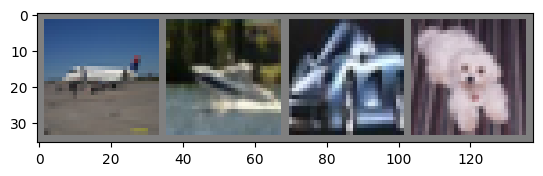

plane ship  car   dog  


In [3]:
def imshow(img):
    img = img/2 + 0.5 #Setting image back to [0, 1] from [-1, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter) 

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)

In [10]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i%2000 == 1999:
            print(f'[{epoch + 1}, {i+1:5d}], loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print("Finished Training")

[1,  2000], loss: 2.230
[1,  4000], loss: 1.922
[1,  6000], loss: 1.723
[1,  8000], loss: 1.608
[1, 10000], loss: 1.567
[1, 12000], loss: 1.511
[2,  2000], loss: 1.464
[2,  4000], loss: 1.405
[2,  6000], loss: 1.377
[2,  8000], loss: 1.364
[2, 10000], loss: 1.341
[2, 12000], loss: 1.311
Finished Training


In [11]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

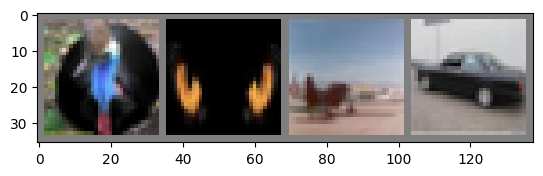

GroundTruth:  bird  cat   plane car  


In [12]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [47]:
net = Net()
net.load_state_dict(torch.load(PATH))
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [48]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print("Predicted: ", ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  dog   cat   cat   plane


In [50]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on 10000 images: {correct / total * 100} %')

Accuracy of the network on 10000 images: 53.97 %


Checking accuracy for specific classes

In [46]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)

        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for class_name, correct_count in correct_pred.items():
    accuracy = correct_count / total_pred[class_name] * 100
    print(f'Accuracy for {class_name} is {accuracy:.1f} %')


Accuracy for plane is 51.0 %
Accuracy for car is 72.7 %
Accuracy for bird is 36.3 %
Accuracy for cat is 50.2 %
Accuracy for deer is 35.1 %
Accuracy for dog is 46.9 %
Accuracy for frog is 62.9 %
Accuracy for horse is 60.4 %
Accuracy for ship is 73.2 %
Accuracy for truck is 51.0 %
